In [ ]:
import pandas as pd
import seaborn as sns
import json


with open("ConvFinQA_test_subset_50_results.json", 'r') as file:
    data = json.load(file)

In [82]:
responses = pd.DataFrame(data['responses'])



responses['correct'] = responses.apply(
    lambda row: 1 if round(row['answer'], 3) == round(row['true_answer'], 3) else 0,
    axis=1
)

In [83]:
import re

def extract_numbers(program_string):

    numbers = re.findall(r'\d+\.\d+|\d+', program_string)

    # Convert all matched numbers to float if they have a decimal, otherwise to int
    extracted_numbers = [float(num) if '.' in num else int(num) for num in numbers]
    
    return extracted_numbers

# Example usage
program = 'subtract(2062, 1375), divide(#0, 1375)'
numbers = extract_numbers(program)
numbers

[2062, 1375, 0, 1375]

In [84]:
def extract_numbers_from_operations(operations):
    numbers = []
    
    for op in operations:
        for key in ['arg_1', 'arg_2']:
            value = op.get(key)
            # Only add the value if it's a number (int or float)
            if isinstance(value, (int, float)):
                numbers.append(int(value))
            if isinstance(value, str):
                numbers.append(int(value.split("_")[1])-1)
    
    return numbers

# Example usage
operations = [
    {'step': 1, 'operation': 'Subtract', 'arg_1': 2062.0, 'arg_2': 1375.0},
    {'step': 2, 'operation': 'Divide', 'arg_1': 'step_1', 'arg_2': 1375.0}
]

numbers = extract_numbers_from_operations(operations)
print(numbers)  # Output: [2062.0, 1375.0, 1375.0]

[2062, 1375, 0, 1375]


In [94]:
responses['pred_program_entities'] = responses.apply(
    lambda row: extract_numbers_from_operations(row['predicted_operations']),
    axis=1
)
responses['true_program_entities'] = responses.apply(
    lambda row: extract_numbers(row['true_program']),
    axis=1
)
responses['entities_correct'] = responses.apply(
    lambda row: 1 if sorted(row['pred_program_entities']) == sorted(row['true_program_entities']) else 0,
    axis=1
)
responses['steps_correct'] = responses.apply(
    lambda row: 1 if row['predicted_steps'] == row['true_steps'] else 0,
    axis=1
)

In [105]:
responses.describe()

,answer,predicted_steps,input_tokens,ouput_tokens,latency,true_steps,true_answer,correct,entities_correct,input_tokens_bucket,steps_correct
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.00000,50.00000
mean,11766.915852,2.460000,1967.880000,226.820000,5.136555,2.22000,4879.692295,0.720000,0.340000,1690.00000,0.86000
std,80376.949663,1.554585,533.815822,124.514353,3.433308,0.46467,31684.932442,0.453557,0.478518,542.95112,0.35051
min,-0.272036,1.000000,971.000000,104.000000,2.727521,2.00000,-0.326870,0.000000,0.000000,500.00000,0.00000
25%,0.044078,2.000000,1630.500000,183.750000,3.525601,2.00000,0.033875,0.000000,0.000000,1500.00000,1.00000
50%,0.400463,2.000000,1972.500000,196.000000,3.867768,2.00000,0.437905,1.000000,0.000000,1500.00000,1.00000
75%,1.201950,2.000000,2249.500000,216.750000,4.916177,2.00000,0.947717,1.000000,1.000000,2000.00000,1.00000
max,568597.000000,12.000000,3483.000000,1007.000000,19.688004,4.00000,224055.000000,1.000000,1.000000,3000.00000,1.00000


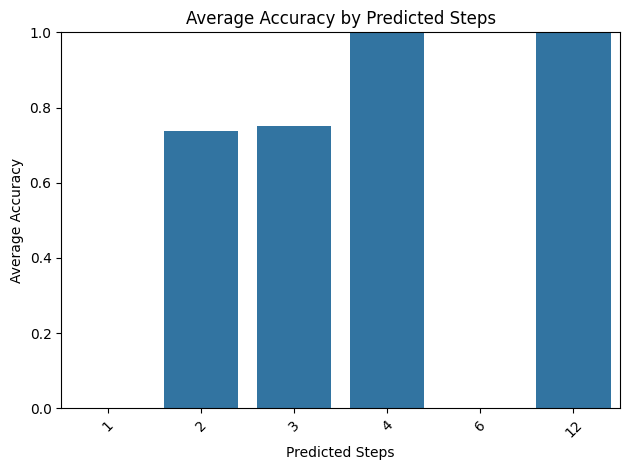

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group the dataset by 'predicted_steps' and calculate the mean of 'correct' column
avg_accuracy = responses.groupby('predicted_steps')['correct'].mean().reset_index()

# Rename columns for clarity
avg_accuracy.columns = ['predicted_steps', 'average_accuracy']

# Plot using seaborn
sns.barplot(data=avg_accuracy, x='predicted_steps', y='average_accuracy')
plt.title('Average Accuracy by Predicted Steps')
plt.xlabel('Predicted Steps')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (if needed)
plt.ylim(0, 1)  # Ensure the y-axis is between 0 and 1 for accuracy
plt.tight_layout()
plt.show()

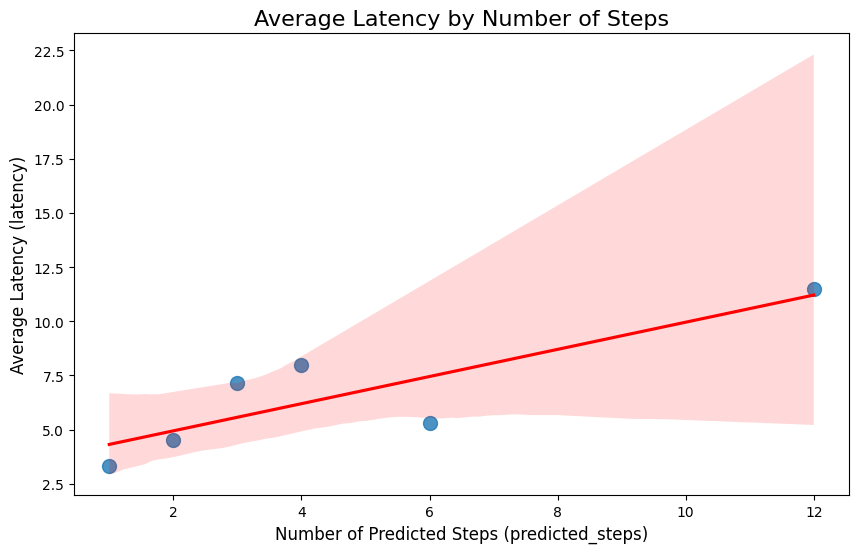

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Group by the 'predicted_steps' column to calculate the mean latency
average_latency = responses.groupby('predicted_steps')['latency'].mean().reset_index()

# Create the scatterplot with a trendline
plt.figure(figsize=(10, 6))
sns.regplot(
    data=average_latency, 
    x='predicted_steps', 
    y='latency', 
    marker='o', 
    scatter_kws={'s': 100},  # Size of scatter points
    line_kws={'color': 'red'},  # Trendline color
)

# Add labels and title
plt.title('Average Latency by Number of Steps', fontsize=16)
plt.xlabel('Number of Predicted Steps (predicted_steps)', fontsize=12)
plt.ylabel('Average Latency (latency)', fontsize=12)

# Show the plot
plt.show()

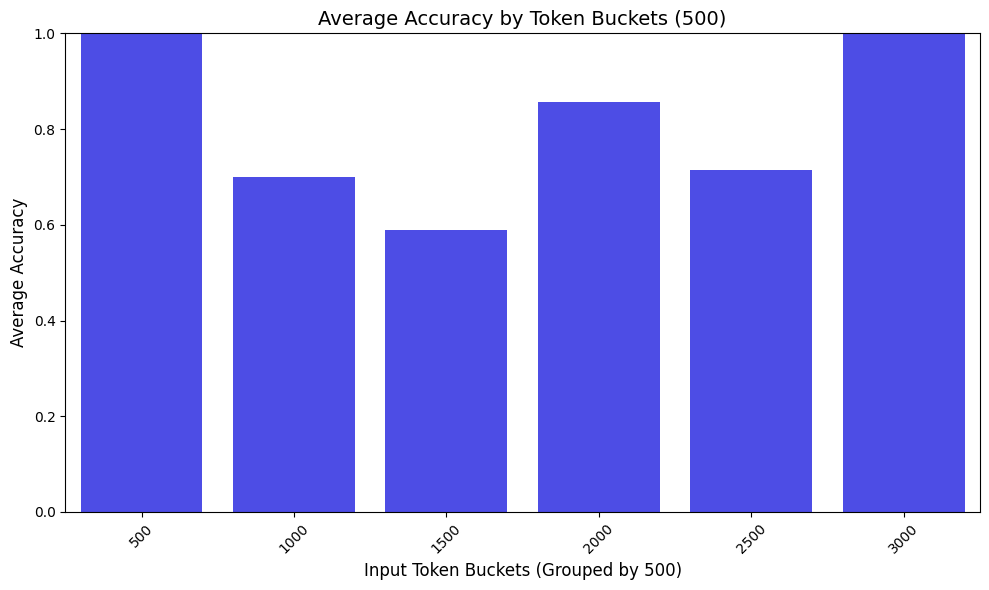

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column that groups input_tokens into buckets of size 500
responses['input_tokens_bucket'] = (responses['input_tokens'] // 500) * 500

# Group by the new input_tokens_bucket and calculate the average accuracy
accuracy_by_bucket = responses.groupby('input_tokens_bucket')['correct'].mean().reset_index()

# Set up a seaborn barplot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=accuracy_by_bucket, x='input_tokens_bucket', y='correct', color="blue", alpha=0.8)

# Customize the plot
plt.xlabel('Input Token Buckets (Grouped by 500)', fontsize=12)
plt.ylabel('Average Accuracy', fontsize=12)
plt.title('Average Accuracy by Token Buckets (500)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.ylim(0, 1)  # Optional: Set y-axis limits based on accuracy values (as accuracy is between 0 and 1)

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/5p/9dyssjln4mdbsh1b30d2019r0000gn/T/ipykernel_34799/1697016918.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_df, x="Step_Type", y="Average_Steps", palette="muted")


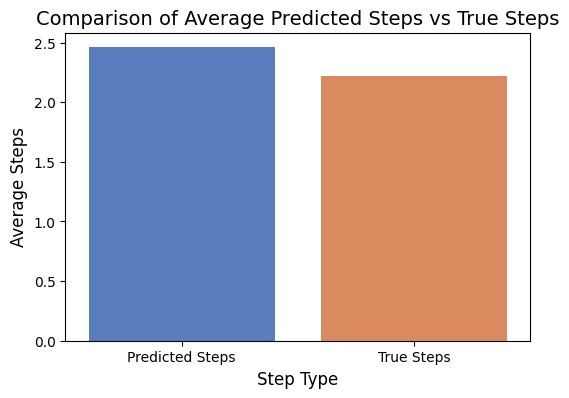

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average values for predicted_steps and true_steps
average_values = {
    "Step_Type": ["Predicted Steps", "True Steps"],
    "Average_Steps": [responses["predicted_steps"].mean(), responses["true_steps"].mean()]
}

# Convert the dictionary to a DataFrame for easier plotting
average_df = pd.DataFrame(average_values)

# Create a bar chart
plt.figure(figsize=(6, 4))
sns.barplot(data=average_df, x="Step_Type", y="Average_Steps", palette="muted")
plt.title("Comparison of Average Predicted Steps vs True Steps", fontsize=14)
plt.ylabel("Average Steps", fontsize=12)
plt.xlabel("Step Type", fontsize=12)
plt.show()

/var/folders/5p/9dyssjln4mdbsh1b30d2019r0000gn/T/ipykernel_34799/2270466724.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Accuracy', data=accuracy_data, palette='viridis')


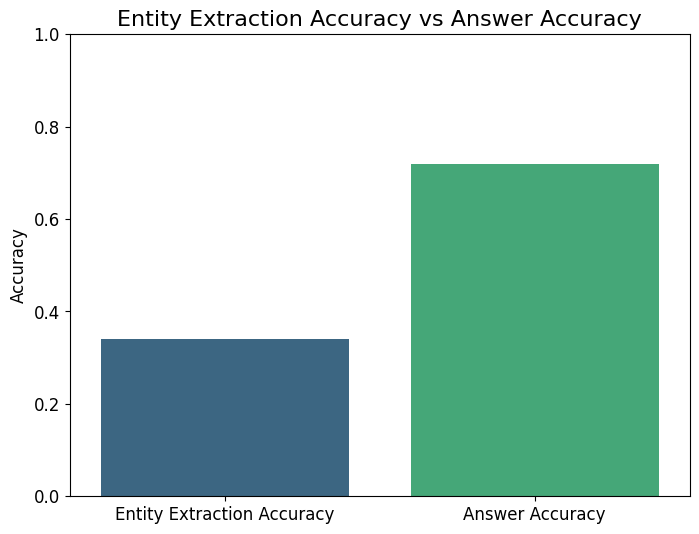

In [91]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Compute accuracy for entity extraction and answer prediction
entity_extraction_accuracy = responses['entities_correct'].mean()
answer_accuracy = responses['correct'].mean()

# Create a new DataFrame with the accuracies
accuracy_data = pd.DataFrame({
    'Metric': ['Entity Extraction Accuracy', 'Answer Accuracy'],
    'Accuracy': [entity_extraction_accuracy, answer_accuracy]
})

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Accuracy', data=accuracy_data, palette='viridis')
plt.title('Entity Extraction Accuracy vs Answer Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('')
plt.ylim(0, 1)  # Accuracy values range from 0 to 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

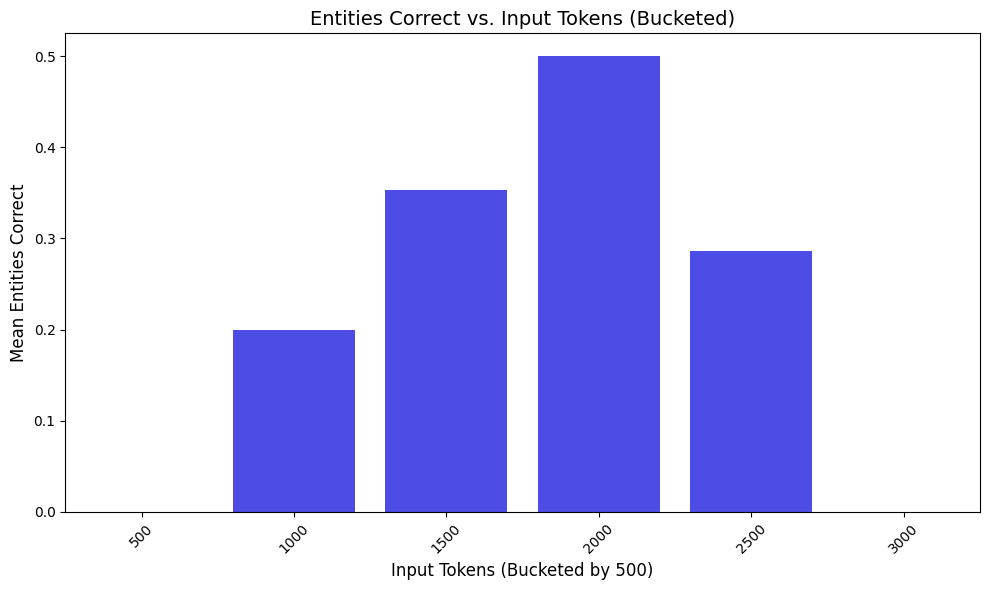

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a new column for input_tokens buckets (bucket size = 500)
responses['input_tokens_bucket'] = (responses['input_tokens'] // 500) * 500

# Aggregate data to calculate the mean of `entities_correct` for each bucket
bucket_data = responses.groupby('input_tokens_bucket', as_index=False)['entities_correct'].mean()

# Plot the data using Seaborn
plt.figure(figsize=(10, 6))  # Set figure size
sns.barplot(data=bucket_data, x='input_tokens_bucket', y='entities_correct', color='blue', alpha=0.8)

# Add labels and title to the plot
plt.xlabel('Input Tokens (Bucketed by 500)', fontsize=12)
plt.ylabel('Mean Entities Correct', fontsize=12)
plt.title('Entities Correct vs. Input Tokens (Bucketed)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

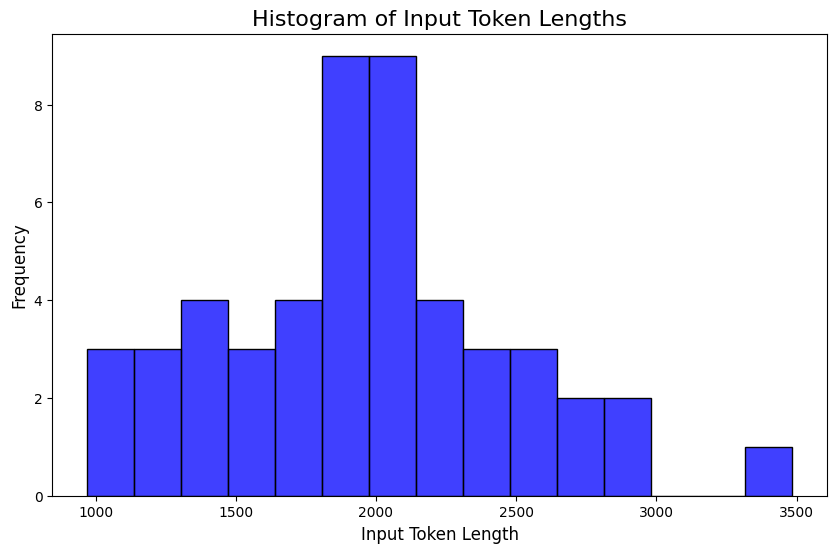

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the histogram data
plt.figure(figsize=(10, 6))
sns.histplot(data=responses, x='input_tokens', bins=15, kde=False, color='blue')

# Add titles and labels
plt.title('Histogram of Input Token Lengths', fontsize=16)
plt.xlabel('Input Token Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

/var/folders/5p/9dyssjln4mdbsh1b30d2019r0000gn/T/ipykernel_34799/2111119789.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_per_bin = responses.groupby('input_tokens_bin')['steps_correct'].mean().reset_index()
/var/folders/5p/9dyssjln4mdbsh1b30d2019r0000gn/T/ipykernel_34799/2111119789.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Input Tokens Bin', y='Accuracy', data=accuracy_per_bin, palette='viridis')


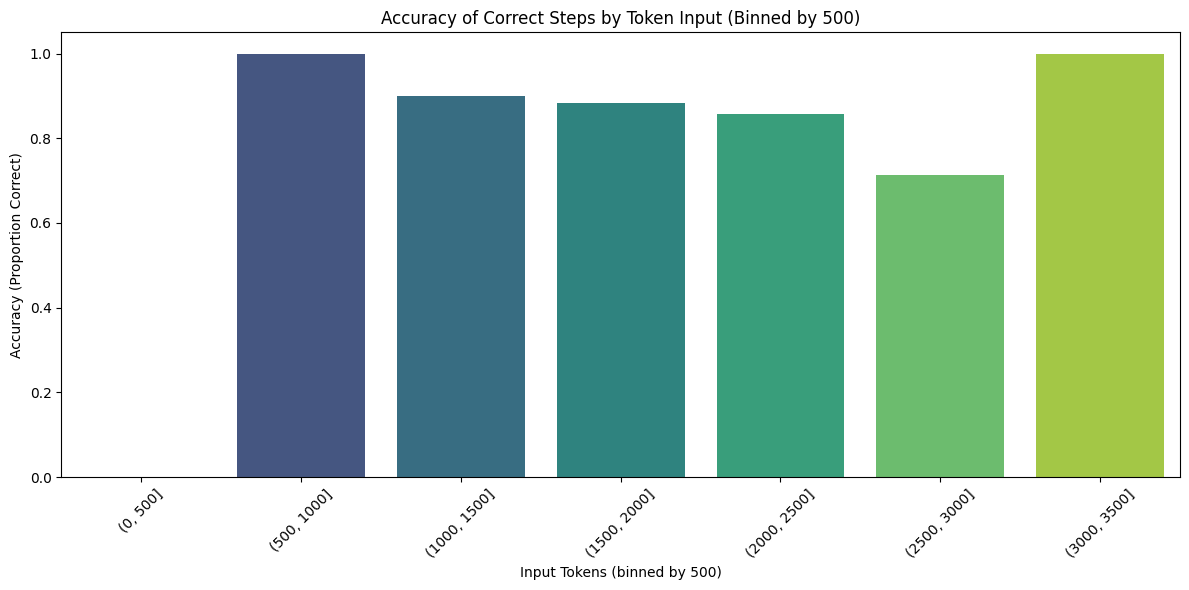

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Add a new column to bucket input_tokens into intervals of 500
responses['input_tokens_bin'] = pd.cut(responses['input_tokens'], bins=np.arange(0, responses['input_tokens'].max() + 500, 500))

# Calculate accuracy (mean of 'correct') for each bin
accuracy_per_bin = responses.groupby('input_tokens_bin')['steps_correct'].mean().reset_index()
accuracy_per_bin.columns = ['Input Tokens Bin', 'Accuracy']

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Input Tokens Bin', y='Accuracy', data=accuracy_per_bin, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Input Tokens (binned by 500)')
plt.ylabel('Accuracy (Proportion Correct)')
plt.title('Accuracy of Correct Steps by Token Input (Binned by 500)')
plt.tight_layout()
plt.show()
